In [63]:
import numpy as np
import matplotlib.pyplot as plt
import Functionsonly as fc
import model_2d as m2
%matplotlib inline

In [64]:
def calc_weights2(opinions_list, confidence, inconfidence, dim=2):
    N, _ = np.shape(opinions_list)
    weight = np.zeros([N, N, dim])

    distance = np.abs(opinions_list[:, np.newaxis, :] - opinions_list[np.newaxis, :, :])
    
    weight = (distance <= confidence).astype(float)
    outside_inconfidence = (distance >= inconfidence).astype(float)
    
    for i in range(N):
        for j in range(N):
            for k in range(dim):
                
                others_near = 0.5 * (np.sum(weight[i, j, :]) - weight[i, j, k]) / dim
                others_far = -1 * np.sum(outside_inconfidence[i, j, :]) / dim
                weight[i, j, k] += (others_near + others_far)

    weight = np.clip(weight, 0, 1)
    
    return weight

def update_opinions(opinions, weights):
    '''
    finds the average of the neighbouring opinions 

    '''
    new_opinions = opinions.copy()
    for i, weight in enumerate(weights):
        new_opinions[i,:] = np.average(opinions, axis=0, weights=weight)  # weighted average
    return new_opinions


def check_convergence_ongoing(model_t1, model_t2, convergence_val):
    '''
    Checks if there is "change" in the model between model_t1 and model_t2

    '''
    if sum([np.linalg.norm(opn_t1-opn_t2) for opn_t1, opn_t2 in zip(model_t1, model_t2)]) < convergence_val:
        return True
    else:
        return False

In [65]:
model1 = np.array([0.7, 0.2, 0.9, 0.2, 0.2, 0.2, 0.6, 0.7, 0, 0, 0, 0, 0.5, 0, 0, 0.6, 0, 1, 1, 1, 0, 1, 0.6, 0.4, 0.7, 0.4, 0.7, 0.5, 0.5, 0.5, 1, 0.2, 0.4, 0.5, 0.5, 1, 0.6, 0.4, 0.8, 0.9, 0.9, 0.6, 0.5, 0.2, 0.7, 0, 1, 0.8, 0.2, 0.3, 0.8, 0.1, 0.7, 0.9, 0, 0.5, 0.5, 0.1, 0.4, 0.3, 0.4, 0.9, 0.5, 0, 0.1, 0.9, 0.3, 0.4, 0.7, 0.3, 0.4, 0.8, 0.8, 0.4, 0.3, 0.7, 0.7, 0.3, 0.5, 0.1, 0.8, 0.9, 0.7, 0.7, 0.6, 0.7, 0.6, 0.1, 0.7, 0.8, 0.6, 0.8, 0.6, 0.5, 0.4, 0.7, 0.8, 0.5, 0.7, 0.5, 0.3, 0.2, 0.1, 0.7, 0.8, 0.4, 0.6, 0.8, 0.6, 0.7, 0.8, 0.2, 0.9, 0.4, 1, 0.7, 0.7, 0, 0.5, 0.6, 0.3, 0.7, 0.7, 0.7, 0.6, 0.1, 0, 0.2, 0.3, 0.4])
model2 = np.array([0.4, 0.4, 0.9, 0.1, 0.6, 0.7, 1, 0.4, 0, 0, 0, 0, 1, 0, 0, 0.5, 0, 1, 1, 1, 0, 1, 0.3, 0.3, 0.7, 1, 1, 1, 0.8, 1, 1, 0, 0.5, 1, 1, 0.5, 0.9, 0.8, 0.2, 1, 1, 0.3, 0.7, 0.8, 0.2, 0, 1, 0.7, 0.7, 0.9, 0.5, 0.3, 0.5, 0.5, 0, 0.9, 1, 0.3, 0.9, 0.9, 1, 1, 0.7, 0, 0.5, 0.8, 0.2, 0.9, 0.9, 0.7, 0.9, 1, 0.2, 0.1, 0.7, 0.8, 0.2, 0, 0.5, 0.1, 0.3, 1, 0.9, 1, 1, 0.3, 0.3, 0.6, 1, 1, 0.7, 0.6, 0.8, 0.5, 0.9, 0.4, 0.9, 0, 0.9, 1, 0.9, 0.7, 0.1, 1, 0.8, 0.9, 1, 1, 0.8, 1, 1, 0.3, 0.9, 0.3, 0.5, 1, 1, 0, 1, 0.7, 0, 0.5, 1, 1, 1, 0.4, 0.3, 0.3, 0.8, 0.9])
# def run_model(num_agents, model1, model2, num_repetitions, confidence, inconfidence, dim = 2, until_convergence = False, convergence_val = 0.0001):
#     # initialization
#     model = np.zeros([num_agents, dim])
#     model[:,0] = model1; model[:,1] = model2
#     model = model.reshape(1,num_agents,dim)
    
#     # do iterations
#     for i in range(1, num_repetitions):
#         weights = m2.calc_weights2(model[i-1], confidence, inconfidence, dim = dim)  # generate new weights
#         new_model = m2.update_opinions(model[i-1], weights)  # update with new weights
#         model = np.concatenate((model, new_model.reshape(1,num_agents,dim)), axis=0)
        
#         if until_convergence == True:
#             if m2.check_convergence_ongoing(model[i], model[i-1], convergence_val) == True:
#                 break
#     return np.array(model)

def run_model(num_agents, model1, model2, num_repetitions, confidence, inconfidence, dim = 2, until_convergence = False, convergence_val = 0.0001):
    # initialization
    model = np.zeros([num_agents, dim])
    model[:,0] = model1; model[:,1] = model2
    model = model.reshape(1,num_agents,dim)
    
    # do iterations
    for i in range(1, num_repetitions):
        weights = calc_weights2(model[i-1], confidence, inconfidence, dim = dim)  # generate new weights
        new_model = update_opinions(model[i-1], weights)  # update with new weights
        model = np.concatenate((model, new_model.reshape(1,num_agents,dim)), axis=0)
        
        if until_convergence == True:
            if check_convergence_ongoing(model[i], model[i-1], convergence_val) == True:
                break
    return np.array(model)

In [75]:
num_agents = 130
num_repetitions = 20
confidence = [0.2, 0.2]
inconfidence = [0.9, 0.9]
dim = 2
model = run_model(num_agents, model1, model2, num_repetitions, confidence, inconfidence, dim = dim, until_convergence = False, convergence_val = 0.0001)
# print(model)

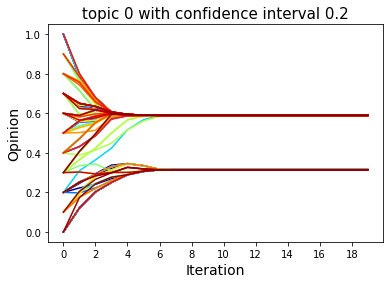

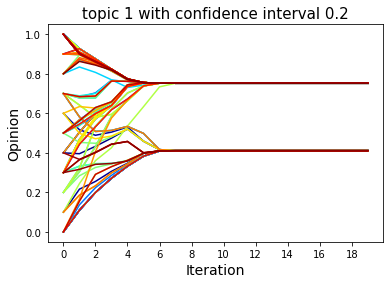

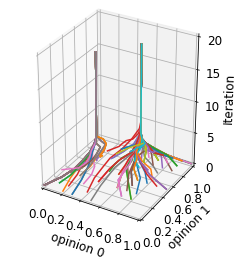

In [76]:
# plot in each dimension
for i in range(dim):
    fc.plot_model_Graph_b(model[:,:,i])
    plt.title(f'topic {i} with confidence interval {confidence[i]}', fontsize=15)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=11))
    # plt.savefig(f"topic{i}_2dplus.pdf", format='pdf')
    plt.show()

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for j in range(model.shape[1]):
    x = model[:, j, 0]
    y = model[:, j, 1]
    z = np.arange(model.shape[0])
    ax.plot(x, y, z)

# ax.set_title("2D model")
ax.set_xlabel("opinion 0", fontsize = 12)
ax.set_ylabel("opinion 1", fontsize = 12)
ax.set_zlabel("Iteration", fontsize = 12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)
ax.set_box_aspect([1.5, 1.5, 2])
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 20]) 

# fig.savefig(f"2dmodel.pdf", format='pdf')
plt.show()